# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

# Why Uncertainty Intervals are better than p-values

Uncertainty Intervals are better than p-values. Sure, its better to use both, but p-values are just a point estimate and they bring no concept of uncertainty in our estimate - this can lead to situations where we expose ourselves to high downside risk.

Take the following example for instance. Let's say we're running a "Do no harm" A/B test where we want to roll out an experiment as long as it doesnt harm conversion rate. 

### The experiment design

Given the stakeholders want to rule out a drop in conversion, and ruling out small differences requires large sample sizes, we decide to design an experiment with good power to detect the presence of a 1/2% absolute drop (if one were to truly exist)

We ran a power analysis and found that in order to have a 90% probability of detecting (`power=0.9`) a 1/2% absolute drop in conversion rate with 80 percent confidence ($\alpha=0.2$), we need `N=32500` per group

> Statisticians might not love this interpretation of a power analysis, but its a useful and interpretable translation and tends to coincide with what we're aiming for anyway. In reality, frequentist power analyses assume that the null hypothesis is correct, which isn't quite what we want, not to mention, frequentist power analyses use backwards probabilities which are just plain confusing - [see here to for more](https://www.fharrell.com/post/pvalprobs/)

Note that we're prioritizing power here for a reason. If $\alpha$ is false positive rate, and power is probability of detection, then don't we want to prioritize our probability of detecting a drop if one truly exists? A false negative here would be more expensive then a false positive

In [2]:
pA = 0.1 # historical conversion rate
abs_delta = 0.005 # minimum detectable effect to test for

# Statsmodels requires an effect size 
# (aka an effect normalized by its standard deviation)
stdev = np.sqrt( pA*(1-pA) ) # bernoulli stdev, sigma = sqrt(p(1-p))
ES = abs_delta / stdev 

# estimate required sample size
sm.stats.tt_ind_solve_power(
    -ES, 
    alpha=0.2,
    power=0.9,
    alternative="smaller"
)

32456.789081212686

### The experiment

I'm going to simulate fake data for this experiment where
 * The __control__ has a __*true*__ conversion rate of 10% 
 * the __variant__ has a __*true*__ conversion rate of 9.25%

For examples sake we'll pretend we don't know that the variant is worse

In [3]:
# Settings
np.random.seed(1325)
N = 32500
pA = 0.1
pB = 0.0925

# Simulation
def simulate_experiment(pA, pB, N_per_group):
    
    df = pd.DataFrame({
        "group":["A"]*N + ["B"]*N,
        "convert":np.r_[
             np.random.binomial(1, p=pA, size=N),
             np.random.binomial(1, p=pB, size=N)
        ]
    })
    
    return df

df = simulate_experiment(pA, pB, N)

In [4]:
# Display
def summarize_experiment(df):
    return (df.groupby("group")["convert"]
             .agg(["mean","sum","count"])
             .rename(columns={"mean":"conversion_rate",
                              "sum":"converts", 
                              "count":"N"}) )
    
display( df.sample(5,random_state=6) )
display( df.pipe(summarize_experiment).round(4) )

,group,convert
56772,B,0
26288,A,0
61637,B,0
44274,B,0
4769,A,0


,conversion_rate,converts,N
group,,,
A,0.0958,3112,32500
B,0.0951,3090,32500


Looking at the data above, we're seeing a better conversion rate in group B. We run a two-proportions z-test and we find that there's a non-significant p-value, meaning we found insufficient evidence of the variant having lower conversion than the control.


We recommend to our stakeholders to roll out the variant since it "does no harm"


In [5]:
def pval_from_summary(tab):
    
    _, pval = sm.stats.proportions_ztest(
        count=tab["converts"][::-1], 
        nobs=tab["N"][::-1],
        alternative="smaller"
    )
    return pval

(df.pipe(summarize_experiment)
   .pipe(pval_from_summary))

0.3844862758159432

There are some serious red flags here
 * First of all, p-values are all about the null hypothesis. So just because we don't find a significant drop in conversion rate, that doesnt mean one doesnt exist. It just means we didnt find evidence for it in this test
 * There was no visualization of the uncertainty in the result
 

## Understanding Uncertainty with the Beta Distribution

For binary outcomes, the beta distribution is highly effective for understanding uncertainty.

It has 2 parameters
 * __alpha__, the number of successes 
 * __beta__, the number of failures
 
It's output is easy to interpret: Its a distribution of plausible probabilities that lead to the outcome.

So we can simply count our successes and failures from out observed data, plug it into a beta distribution to simulate outcomes, and visualize it as a density plot to understand uncertainty

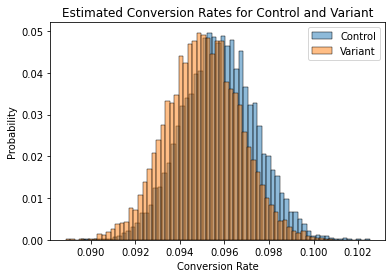

In [6]:
def beta_dist_from_summary(tab, nsamples=10000):
    
    successA = tab.loc["A", "converts"]
    successB = tab.loc["B", "converts"]
    failuresA = N - successA
    failuresB = N - successB

    pA_hat = np.random.beta(successA, failuresA, size=nsamples)
    pB_hat = np.random.beta(successB, failuresB, size=nsamples)
    return pA_hat, pB_hat

pA_hat, pB_hat = (df.pipe(summarize_experiment)
                    .pipe(beta_dist_from_summary))

plt.title("Estimated Conversion Rates for Control and Variant")
sns.histplot(pA_hat, stat="probability", alpha=0.5, label="Control")
sns.histplot(pB_hat, stat="probability", alpha=0.5, label="Variant", color="C1")
plt.xlabel("Conversion Rate")
plt.legend();



If we want to understand the plausible differences between groups, we can just take the differences in our estimates

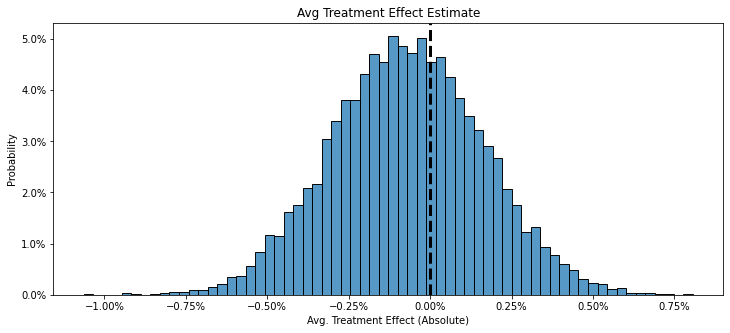

In [7]:
def plot_mu_diff(pA_hat, pB_hat):
    
    mu_diff = (pB_hat - pA_hat)

    fig, ax = plt.subplots(1,1,figsize=(12,5))

    ax.set_title("Avg Treatment Effect Estimate")
    sns.histplot(mu_diff, stat="probability",ax=ax)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=2))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax.set_xlabel("Avg. Treatment Effect (Absolute)")
    ax.axvline(0, ls="--",color="k", lw=3)
    
plot_mu_diff(pA_hat, pB_hat)

With visualization, we get a very different picture than our non-significant p-value. We see that there's plenty of plausibility that the control could be worse.

We can further calculate the probability of a drop, $P(B < A)$, and find that theres a greater than 60% probability that the variant is worse than the control

In [8]:
# P(B < A)
(pB_hat < pA_hat).mean()

0.6216

Remember when we designed the experiment? Considering our main goal was to do no harm, we might not feel so confident in that now, and rightly so, we know the variants worse since we simulated it. 

Unless we feel very confident in our choice of testing for a 1/2% drop and know that we can afford anything up to that, then we we really shouldnt roll out this variant without further evaluation


This is particularly important with higher uncertainty As we can see in the example below, where the observed conversion rate is better in the variant, but the downside risk is as high as a 4% drop in conversion rate

,conversion_rate,converts,N
group,,,
A,0.102,102,1000
B,0.105,105,1000


p = 0.59


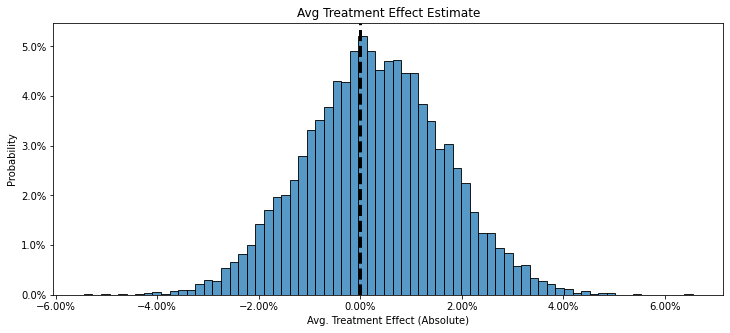

In [9]:
# Settings
np.random.seed(1)
N = 1000
pA = 0.1
pB = 0.09

# Simulation
df = simulate_experiment(pA, pB, N)
display( df.pipe(summarize_experiment) )

# Get pval for testing that the variant is smaller 
print("p = {:.2}".format(
    df.pipe(summarize_experiment)
    .pipe(pval_from_summary))
)


plot_mu_diff(
    *df.pipe(summarize_experiment)
       .pipe(beta_dist_from_summary)
)


# Another example: Which metric?

This is a fun problem from @seanjtaylor
> "You run a product test and measure a strong positive effect on your first metric. 

> Metric 1: +1% (p<.01)

> You also see a negative, but not significant result on equally important Metric 2. You only care about these two metrics. Which of these estimates would you prefer to ship?"
 
> 1. <input type="checkbox" unchecked> Metric 2: -0.5% (p = 0.10)
> 2. <input type="checkbox" unchecked> Metric 2: -0.5% (p=0.45)
> 3. <input type="checkbox" unchecked> Neither is shippable 

If you chose option 2, you weren't alone. Option 1 makes it seem like there's a more likely negative effect due to the lower p-value, so thats worse, right?

Not quite. Check out the uncertainties of these. The downside risk option 2 is much worse than option 1.

In [171]:
N = 20000

# Simulating fake average treatment effects 
metric1_ATE = np.random.normal(0.01, 0.003, size=N)
metric2_ATE_p10 = np.random.normal(-0.005, 0.0025, size=N)
metric2_ATE_p45 = np.random.normal(-0.005, 0.005, size=N)

data = pd.DataFrame({
    "metric1_ATE":metric1_ATE,
    "metric2_ATE_p10":metric2_ATE_p10,
    "metric2_ATE_p45":metric2_ATE_p45

})

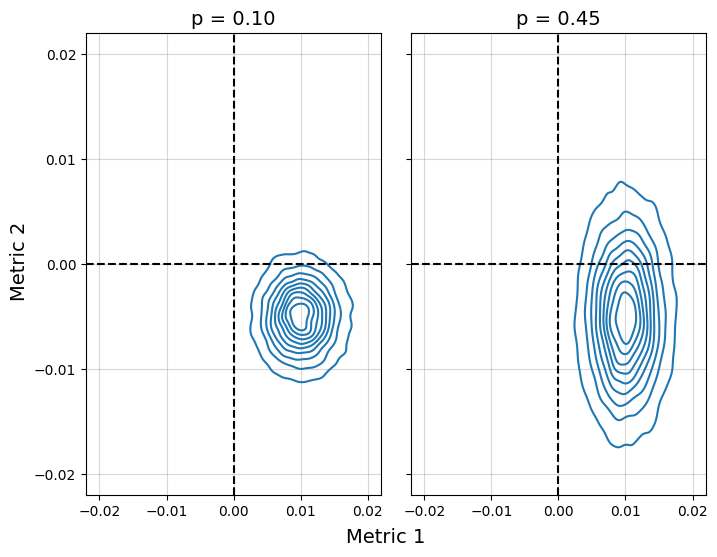

In [172]:
fig, ax = plt.subplots(1,2, figsize=(8,6), sharey=True, sharex=True)
                      
sns.kdeplot(
    data=data, 
    x="metric1_ATE", 
    y="metric2_ATE_p10", 
    ax=ax[0],

)

sns.kdeplot(
    data=data, 
    x="metric1_ATE", 
    y="metric2_ATE_p45", 
    ax=ax[1],
    
)

# Plot settings
for plot, pval in zip(ax.ravel(), ["0.10", "0.45"]):
    plot.axhline(0, ls="--", color="k")
    plot.axvline(0, ls="--", color="k")
    plot.set_xlim(-0.022, 0.022)
    plot.set_ylim(-0.022, 0.022)
    plot.set_title(f"p = {pval}", fontsize=14)
    plot.set_xlabel("")
    plot.set_ylabel("")
    plot.grid(alpha=0.5)
    plot.set_yticks(np.arange(-.02, .02+.01, .01))

fig.text(0.5, 0.03, 'Metric 1', ha='center', fontsize=14)
fig.text(0.03, 0.5, 'Metric 2', va='center', rotation='vertical', fontsize=14)
plt.subplots_adjust(wspace=0.1)


Not only that, but we can add our effects (remember we assumed the metrics are equally important), and see if it's overall net positive 

In [173]:
import arviz as az

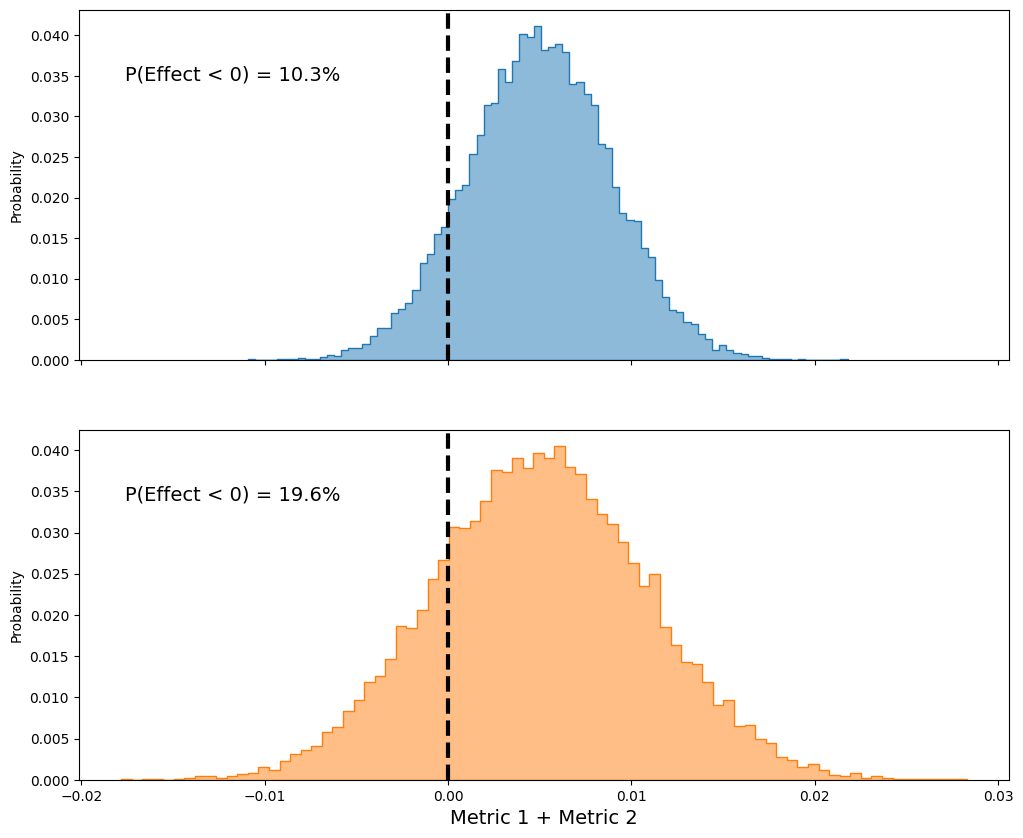

In [174]:
plt.style.use("default")
m1 = data["metric1_ATE"]
m2_p10 = data["metric2_ATE_p10"]
m2_p45 = data["metric2_ATE_p45"]

option1 = m1 + m2_p10
option2 = m1 + m2_p45

fig, ax = plt.subplots(2,1,figsize=(12,10), sharex=True)
sns.histplot( option1, ax=ax[0], stat="probability", alpha=0.5, element="step" )
sns.histplot( option2, ax=ax[1], stat="probability", color="C1", alpha=0.5, element="step" )

risks = [(option1 < 0).mean(), (option2 < 0).mean()]
for plot, risk in zip(ax.ravel(), risks):
    plot.axvline(0, ls="--", color="k", lw=3)
    plot.annotate("P(Effect < 0) = {:.1%}".format(risk), 
                  (0.05, 0.8), xycoords="axes fraction", fontsize=14)
    plot.set_xlabel("Metric 1 + Metric 2", fontsize=14)
    

As shown above, the non significant p value option has a higher probability of being negative, AND it gives more plausibility to more negative possible effects

# Summary

Always report uncertainty intervals - p-values definitely dont tell the whole story, even with well designed experiments. As we saw, ignoring uncertainty can expose ourselves to high downside, especially when our choice in experiment design has even the slightest bit of arbitrary choices involved (such as an arbitrary minimum detectable effecs)

Reporting uncertainty intervals or beta distributions (or even bootstrapping) can be a great way to avoid falling for this mistake